In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

import xarray as xr
import pandas as pd
import numpy as np
import scipy.io as io

from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
from deepflow.plotting_utils import create_simulation_time_axis, colorbar, extract_min_misfits, load_folders
from deepflow.plotting_utils import get_unconditionals, plot_row_curves, plot_row_envelopes
from deepflow.plotting_utils import determine_connected

## Setting parameters for importing and plotting

In [3]:
plot = False
working_dir = './results/runs/'
perm = "low_perm"

#Creates the simulation time axis
dts = create_simulation_time_axis()

#Load the ground truth case from the test set, corresponds to test set model 67
gt = np.load("./reference/model_67_x.npy")
envelope = gt[0, :, ::-1].T

In [4]:
ds_ref = xr.open_dataset(working_dir+perm+'/reference/reference_noise.nc')
qor_ref = ds_ref['state_variables'][dict(state_variable=2, well=1)]*(-60*60*24)
qwr_ref = ds_ref['state_variables'][dict(state_variable=1, well=1)]*(-60*60*24)
p_ref = ds_ref['state_variables'][dict(state_variable=0, well=0)]/1e5

ref_curves = [qor_ref, qwr_ref, p_ref]

## Loading Unconditional Prior Pressure, Rate and Property Distribution Data|

In [5]:
unc_curves, unc_poros, unc_perms, unc_zs, unc_misfits = get_unconditionals('./results/runs/', perm)

99
199
299
399
499
599
699
799
899
999


In [6]:
unc_props = np.concatenate([unc_poros.reshape(1000, 1, 64, 128), unc_perms.reshape(1000, 1, 64, 128)], 1)

## Loading the optimized samples for each inversion case: wells, flow, and flow+wells

In [7]:
folders = [perm+a for a in ["/wells_adam_bce", "/flow_adam_bce", "/flowwells_adam_bce"]]
all_curves, all_poroperms, all_zs = load_folders("./results/runs/", folders, functionals=["min_map", "min_map", "min_map"])

In [8]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [14, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

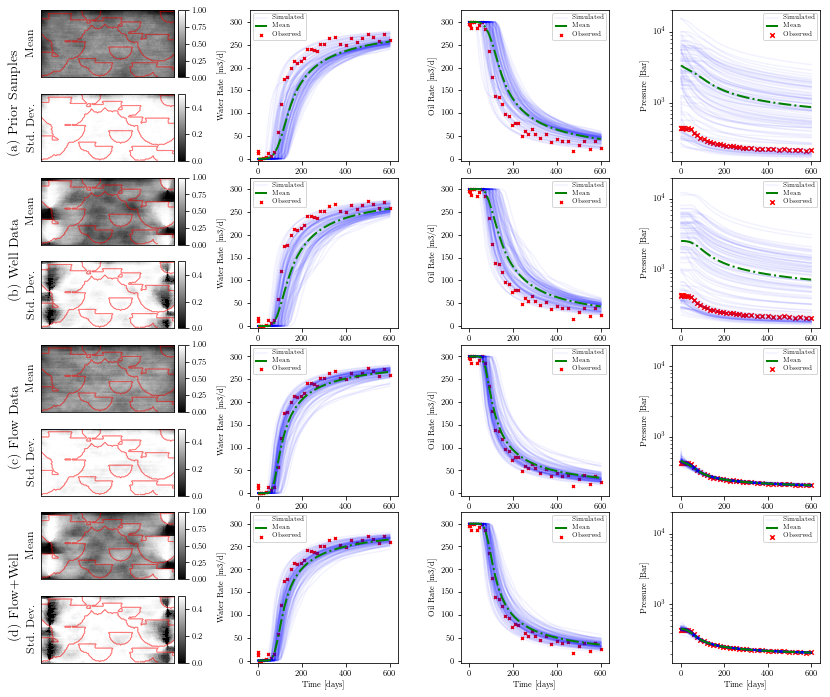

In [10]:
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=0.25)
plot_row_curves(0, unc_props[0:100], unc_curves[0:100], ref_curves, dts, envelope,  desc="(a) Prior Samples")
plot_row_curves(2, all_poroperms[0][0], all_curves[0][0], ref_curves, dts, envelope, desc="(b) Well Data")
plot_row_curves(4, all_poroperms[1][0], all_curves[1][0], ref_curves, dts, envelope, desc="(c) Flow Data")
plot_row_curves(6, all_poroperms[2][0], all_curves[2][0], ref_curves, dts, envelope, desc="(d) Flow+Well")
if plot:
    plt.savefig("./results/figures/all_runs_gt.png", dpi=300, bbox_inches="tight")

## Plotting all the MAP models for the four considered scenarios

In [13]:
import torch
import random

def inverse_permeability_transform(x, a=0.001, b=1e-12):
    return x/b-a

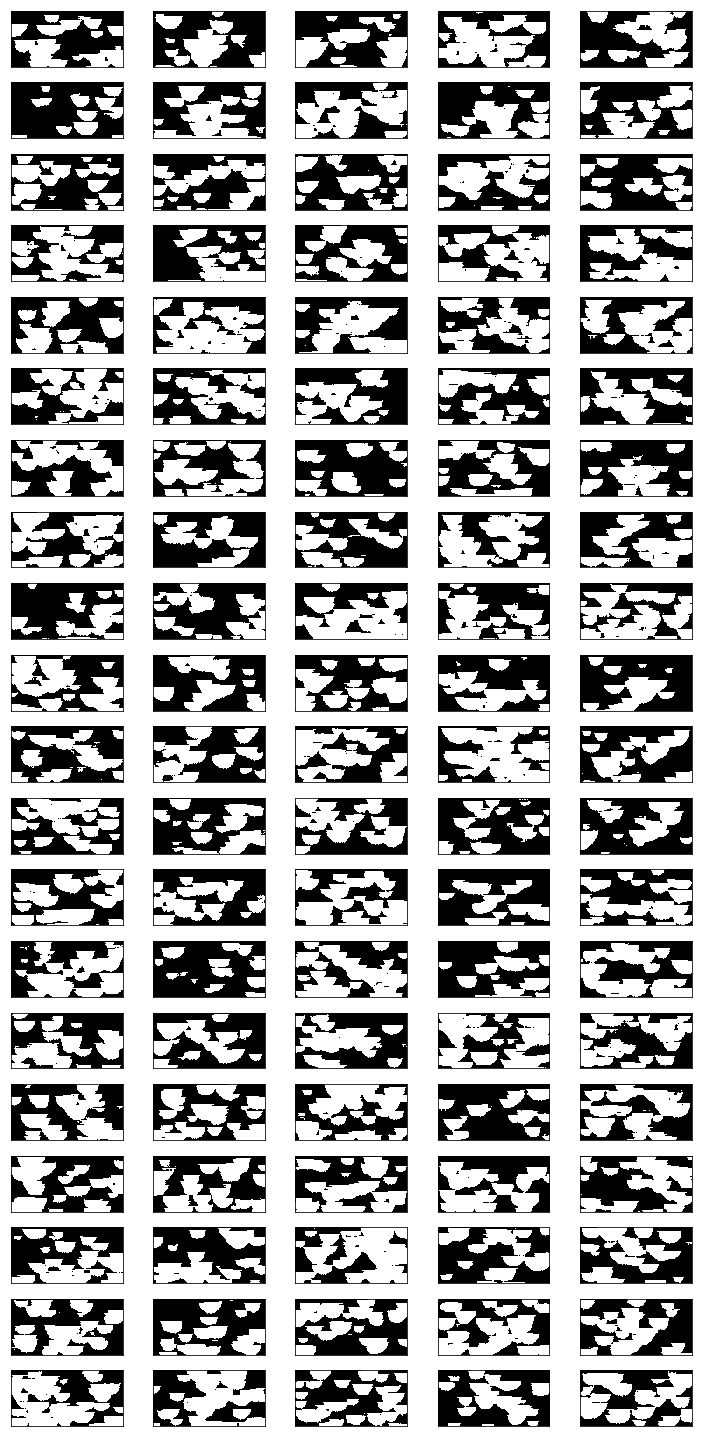

In [14]:
fig, ax = plt.subplots(20, 5, figsize=(10, 20))
p = np.array([np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1] for poro_perm in unc_props[0:100]])

for a, im in zip(ax.flatten(), p):
    a.imshow(im, vmin=0, vmax=1.0)
    
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()
if plot:
    plt.savefig("./results/figures/unconditional_samples.png", dpi=300, bbox_inches="tight")

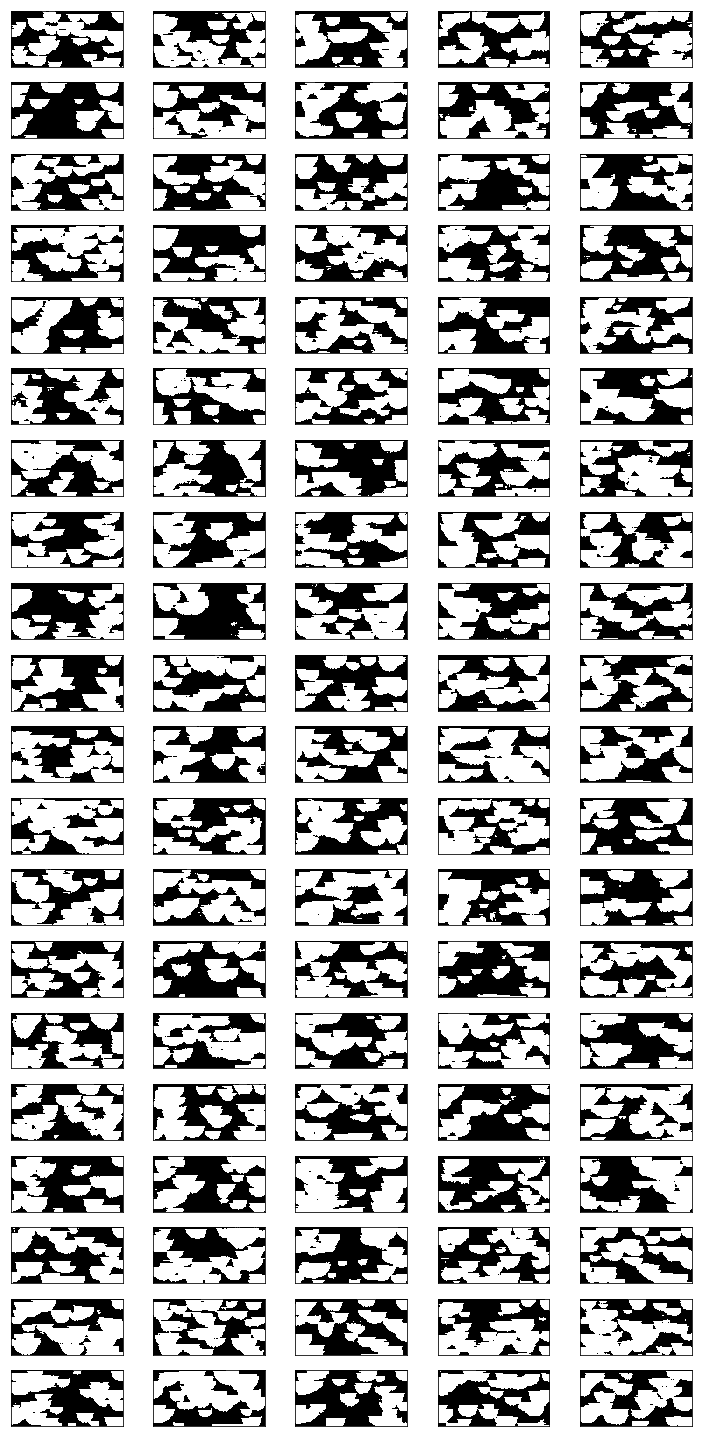

In [15]:
misfits_wells = np.load("./results/misfits/low_perm/misfits_wells_adam_gauss_bce.npy")

fig, ax = plt.subplots(20, 5, figsize=(10, 20))
imgs = [np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1] for poro_perm in all_poroperms[0][0]]

for a, im in zip(ax.flatten(), imgs):
    a.imshow(im, vmin=0, vmax=1.0)
    
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()
if plot:
    plt.savefig("./results/figures/wells_samples.png", dpi=300, bbox_inches="tight")

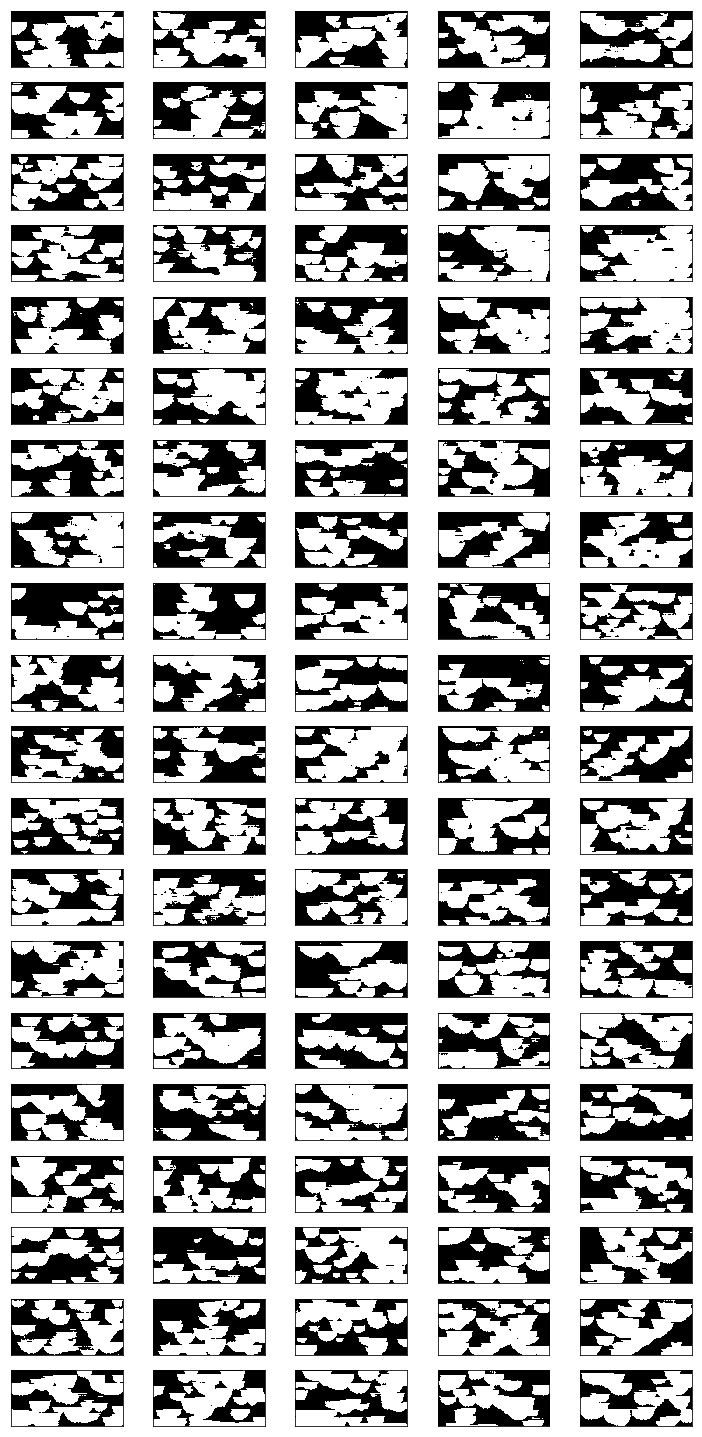

In [16]:
misfits_flow = np.load("./results/misfits/low_perm/misfits_flow_adam_gauss_bce.npy")

fig, ax = plt.subplots(20, 5, figsize=(10, 20))
imgs = np.array([np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1] for poro_perm in all_poroperms[1][0]])

for a, im in zip(ax.flatten(), imgs):
    a.imshow(im, vmin=0, vmax=1.0)
    
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()
if plot:
    plt.savefig("./results/figures/flow_samples.png", dpi=300, bbox_inches="tight")

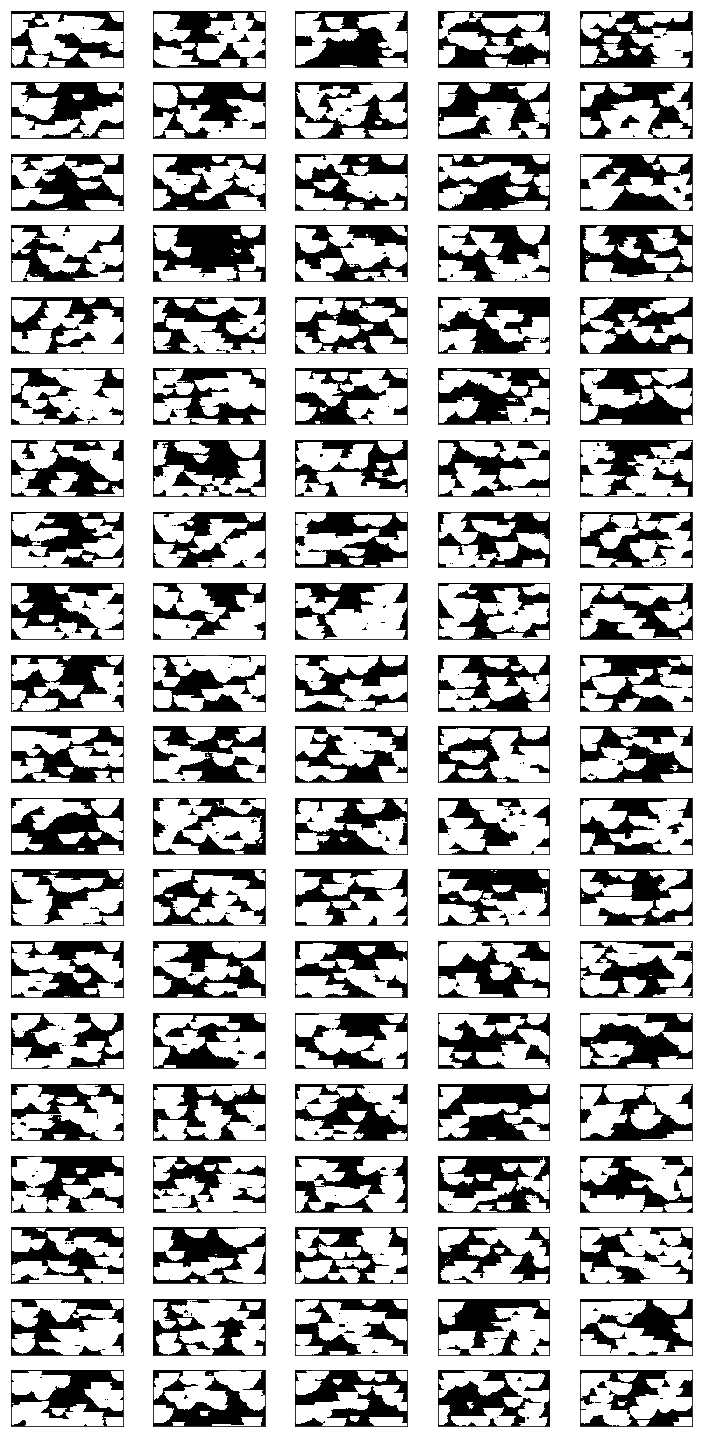

In [17]:
misfits_flowwells = np.load("./results/misfits/low_perm/misfits_flowwells_adam_gauss_bce.npy")

fig, ax = plt.subplots(20, 5, figsize=(10, 20))
imgs = np.array([np.where(inverse_permeability_transform(poro_perm[1])>0.5, 1, 0)[::-1] for poro_perm in all_poroperms[2][0]])

for a, im in zip(ax.flatten(), imgs):
    a.imshow(im, vmin=0, vmax=1.0)
    
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()
if plot:
    plt.savefig("./results/figures/flowwells_samples.png", dpi=300, bbox_inches="tight")